In [21]:
# Import dependencies
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from joblib import dump

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

import pandas as pd
import numpy as np

import seaborn as sns 
from nltk.tokenize.treebank import TreebankWordDetokenizer
from nltk.corpus import stopwords
from nltk import word_tokenize

import nltk

from keras.models import Model, load_model
from keras.layers import Dense, Embedding, Input, Activation, CuDNNGRU, Bidirectional, Dropout, GlobalMaxPooling1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback

In [2]:
# Read in CSV File
raw_data = pd.read_csv('db/wine_library.csv', dtype = {'Zip': 'str'})
raw_data.head(2)

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez


In [3]:
raw_data["country"].unique()

array(['US', 'Spain', 'France', 'Italy', 'New Zealand', 'Bulgaria',
       'Argentina', 'Australia', 'Portugal', 'Israel', 'South Africa',
       'Greece', 'Chile', 'Morocco', 'Romania', 'Germany', 'Canada',
       'Moldova', 'Hungary', 'Austria', 'Croatia', 'Slovenia', nan,
       'India', 'Turkey', 'Macedonia', 'Lebanon', 'Serbia', 'Uruguay',
       'Switzerland', 'Albania', 'Bosnia and Herzegovina', 'Brazil',
       'Cyprus', 'Lithuania', 'Japan', 'China', 'South Korea', 'Ukraine',
       'England', 'Mexico', 'Georgia', 'Montenegro', 'Luxembourg',
       'Slovakia', 'Czech Republic', 'Egypt', 'Tunisia', 'US-France'],
      dtype=object)

In [4]:
# Drop the columns and NaN values in it
# NOTE: Only dropping NaN values from country and price. If I dropped NaN values from region_2 then I only have 9 
# countries, losing too much data.

dropped_data = raw_data.drop(['designation', 'Unnamed: 0'], axis = 1) 
wine_data = dropped_data.dropna(subset=['price', 'country'])
wine_data.head(3)

,country,description,points,price,province,region_1,region_2,variety,winery
0,US,This tremendous 100% varietal wine hails from ...,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez
2,US,Mac Watson honors the memory of a wine once ma...,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley


# Prepare the data for ML - clean description 

In [5]:
# set seaborn style 
sns.set(style="whitegrid")

In [6]:
stopwords = set(stopwords.words('english'))
detokenizer = TreebankWordDetokenizer()

In [7]:
# Create a function that would clean description column
def clean_description(desc):
    
# convert to lower cases
    desc = word_tokenize(desc.lower())
    desc = [token for token in desc if token not in stopwords and token.isalpha()]
    return detokenizer.detokenize(desc)

In [8]:
# Use apply method to create cleaned description column
wine_data["cleaned_description"] = wine_data["description"].apply(clean_description)
wine_data.head(2)

/anaconda3/envs/PythonData/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,country,description,points,price,province,region_1,region_2,variety,winery,cleaned_description
0,US,This tremendous 100% varietal wine hails from ...,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz,tremendous varietal wine hails oakville aged t...
1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez,ripe aromas fig blackberry cassis softened swe...


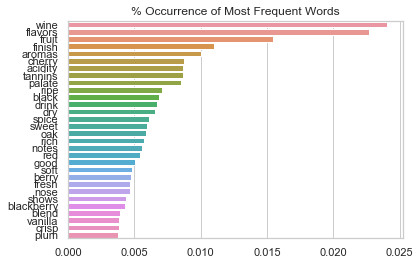

In [9]:
# Plot for the most frequent words occurence
word_occurrence = wine_data["cleaned_description"].str.split(expand=True).stack().value_counts()
total_words = sum(word_occurrence)

# plot most common words 
top_words = word_occurrence[:30]/total_words

# assign x and y on the plot
ax = sns.barplot(x = top_words.values, y = top_words.index)

# Setting the title to the graoh
ax.set_title("% Occurrence of Most Frequent Words")

plt.show()

# Prepare the data for ML - Map the reviews by points into classes

In [10]:
# defining function to get the points into buckets 
# NOTE: refer to this article (classification) https://www.winemag.com/2019/01/02/wine-vintage-chart-2019/
def buckets(points):
    if points in range(80,85): 
        return 4
    elif points in range(85,90):
        return 3
    elif points in range(90,95):
        return 2
    else:
        return 1

# Apply method to get an additional column with points in the buckets => labels
wine_data["labels"] = wine_data["points"].apply(buckets)
wine_data.head(2)

/anaconda3/envs/PythonData/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,country,description,points,price,province,region_1,region_2,variety,winery,cleaned_description,labels
0,US,This tremendous 100% varietal wine hails from ...,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz,tremendous varietal wine hails oakville aged t...,1
1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez,ripe aromas fig blackberry cassis softened swe...,1


In [11]:
# Verify data is of correct type
wine_data.dtypes

country                 object
description             object
points                   int64
price                  float64
province                object
region_1                object
region_2                object
variety                 object
winery                  object
cleaned_description     object
labels                   int64
dtype: object

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a481b3630>,
      dtype=object)

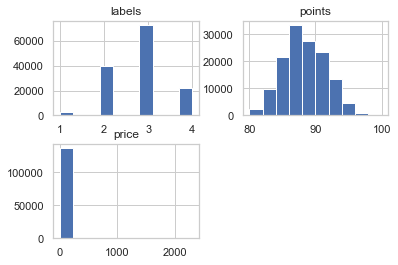

In [12]:
wine_data.hist()

In [13]:
# Checking if the labels were broken into unique buckets 
wine_data["labels"].unique()

array([1, 2, 3, 4])

In [14]:
# Checking the number of reviews for the weights assigning later
wine_data.groupby('labels').size()

labels
1     2514
2    39936
3    72571
4    22209
dtype: int64

In [18]:
# Defining fixed parameters
num_classes = 4

# dimensions of the word vectors
embedding_dim = 300

epochs = 50

# number of training exmples 
batch_size = 100

# max len of words in one exampel
max_len = 100

# because the classes are not very balanced, we should balance them 
class_weights = {1: 7,
                2: 1, 
                3: 1,
                4: 2}

In [23]:
# One hot encoding target
def onehot(arr, num_classes):
    return np.eye(num_classes)[np.array(arr.astype(int)).reshape(-1)]

y = onehot(wine_data["labels"], num_classes)

IndexError: index 4 is out of bounds for axis 0 with size 4